# Dataset Loading

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d nikhileswarkomati/suicide-watch
!unzip suicide-watch.zip


Saving kaggle.json to kaggle.json
 94% 57.0M/60.6M [00:01<00:00, 49.1MB/s]
100% 60.6M/60.6M [00:01<00:00, 56.8MB/s]
Archive:  suicide-watch.zip
  inflating: Suicide_Detection.csv   


# Data Pre-processing

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('Suicide_Detection.csv')
data[:20]

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
5,11,Honetly idkI dont know what im even doing here...,suicide
6,12,[Trigger warning] Excuse for self inflicted bu...,suicide
7,13,It ends tonight.I can’t do it anymore. \nI quit.,suicide
8,16,"Everyone wants to be ""edgy"" and it's making me...",non-suicide
9,18,My life is over at 20 years oldHello all. I am...,suicide


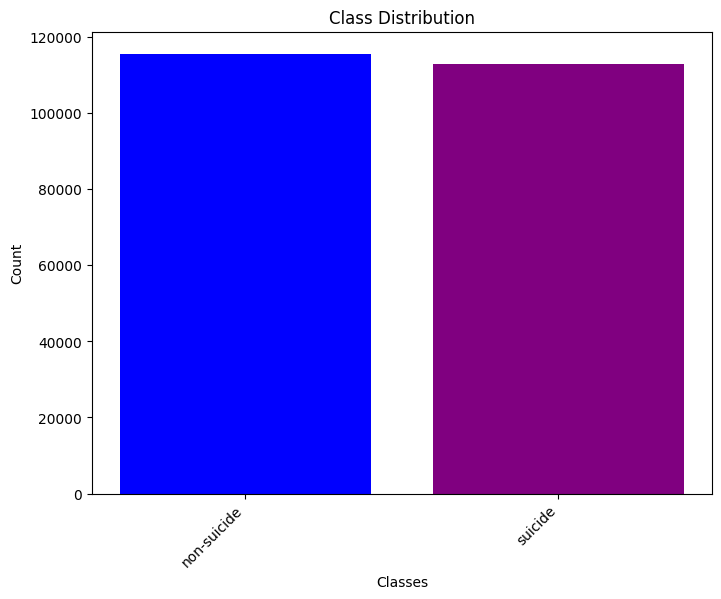

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'data' with a column 'label' containing class labels.

# Calculate class distribution
class_counts = data['class'].value_counts()

# Sort classes based on their counts in descending order
class_counts = class_counts.sort_values(ascending=False)

# Define colors for the bars (one color for each class)
colors = ['blue', 'purple']

# Plot the class distribution using a bar plot with different colors
plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values, color=colors)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')
plt.show()



In [ ]:
!pip install pandas nltk symspellpy contractions spacy
!python -m spacy download en_core_web_sm

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
# Install missing libraries
!pip install unidecode wordninja pyspellchecker
import unidecode
import contractions as contract
import spacy
import wordninja
import collections
import pkg_resources
from symspellpy import SymSpell, Verbosity
from spellchecker import SpellChecker



nltk.download("punkt")
nltk.download("stopwords")
nltk.download("words")



# Step 2: Data Cleaning
# Drop rows with missing values
data.dropna(inplace=True)

# Defining methods
nlp = spacy.load("en_core_web_sm")
vocab = collections.Counter()
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename("symspellpy", "frequency_bigramdictionary_en_243_342.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

# Spell Check using Symspell
def fix_spelling(text):
    suggestions = sym_spell.lookup_compound(text, max_edit_distance=2)
    corrected_text = suggestions[0].term  # get the first suggestion, otherwise returns original text if nothing is corrected
    return corrected_text

# Remove some important words from stopwords list
deselect_stop_words = ['no', 'not']

for w in deselect_stop_words:
    nlp.vocab[w].is_stop = False

# Remove extra whitespaces from text
def remove_whitespace(text):
    text = text.strip()
    return " ".join(text.split())

# Remove accented characters from text, e.g. café
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text

# Remove URL
def remove_url(text):
    return re.sub(r'http\S+', '', text)

# Removing symbols and digits
def remove_symbols_digits(text):
    return re.sub('[^a-zA-Z\s]', ' ', text)

# Removing special characters
def remove_special(text):
    return text.replace("\r", " ").replace("\n", " ").replace("    ", " ").replace('"', '')

# Fix word lengthening (characters are wrongly repeated)
def fix_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

def text_preprocessing(text, accented_chars=True, contractions=True, convert_num=True,
                       extra_whitespace=True, lemmatization=True, lowercase=True,
                       url=True, symbols_digits=True, special_chars=True,
                       stop_words=True, lengthening=True, spelling=True):
    """preprocess text with default option set to true for all steps"""
    if accented_chars == True: # remove accented characters
        text = remove_accented_chars(text)
    if contractions == True: # expand contractions
        text = contract.fix(text)
    if lowercase == True: # convert all characters to lowercase
        text = text.lower()
    if url == True: # remove URLs before removing symbols
        text = remove_url(text)
    if symbols_digits == True: # remove symbols and digits
        text = remove_symbols_digits(text)
    if special_chars == True: # remove special characters
        text = remove_special(text)
    if extra_whitespace == True: # remove extra whitespaces
        text = remove_whitespace(text)
    if lengthening == True: # fix word lengthening
        text = fix_lengthening(text)
    if spelling == True: # fix spelling
        text = fix_spelling(text)

    doc = nlp(text) # tokenise text

    clean_text = []

    for token in doc:
        flag = True
        edit = token.text
        # remove stop words
        if stop_words == True and token.is_stop and token.pos_ != 'NUM':
            flag = False
        # exclude number words
        if convert_num == True and token.pos_ == 'NUM' and flag == True:
            flag = False
        # convert tokens to base form
        elif lemmatization == True and token.lemma_ != "-PRON-" and flag == True:
            edit = token.lemma_
        # append tokens edited and not removed to list
        if edit != "" and flag == True:
            clean_text.append(edit)
    return " ".join(clean_text)

# Apply the text_preprocessing function to the entire 'text' column and store the preprocessed text in 'cleaned_text'
data['cleaned_text'] = data['text'].apply(lambda row: text_preprocessing(row))

# Data Cleaning: Remove irrelevant words
irrelevant_words = ["xyz", "irrelevant", "remove", "me"]
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in irrelevant_words]))

# Data Cleaning: Remove rows that do not contain any words
data['word_count'] = data['cleaned_text'].apply(lambda x: len(x.split()))
data = data[data['word_count'] > 0]

# Data Cleaning: Remove outliers in word count of texts
word_count_mean = data['word_count'].mean()
word_count_std = data['word_count'].std()
outlier_threshold = word_count_mean + 3 * word_count_std
data = data[data['word_count'] <= outlier_threshold]

# Drop the temporary 'word_count' column
data.drop(columns=['word_count'], inplace=True)
data.to_csv('preprocessed_data.csv', index=False)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 21.5 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
data[:20]

,Unnamed: 0,text,class,cleaned_text
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,sex wife threaten suicide recently leave wife ...
1,3,Am I weird I don't get affected by compliments...,non-suicide,weird not affect compliment come know girl fee...
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,finally hear bad year swear fucking god annoying
3,8,i need helpjust help me im crying so hard,suicide,need help help cry hard
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,lose hello adam struggle year afraid past year...
5,11,Honetly idkI dont know what im even doing here...,suicide,honestly d not know feel like feel unbearably ...
6,12,[Trigger warning] Excuse for self inflicted bu...,suicide,trigger warn excuse self inflict burn know cri...
7,13,It ends tonight.I can’t do it anymore. \nI quit.,suicide,end tonight not anymore quit
8,16,"Everyone wants to be ""edgy"" and it's making me...",non-suicide,want edgy make self conscious feel like not st...
9,18,My life is over at 20 years oldHello all. I am...,suicide,life year old hello year old bald male hairlin...


count    228428.000000
mean         44.983470
std          52.525107
min           1.000000
25%          11.000000
50%          24.000000
75%          58.000000
max         314.000000
Name: word_count, dtype: float64


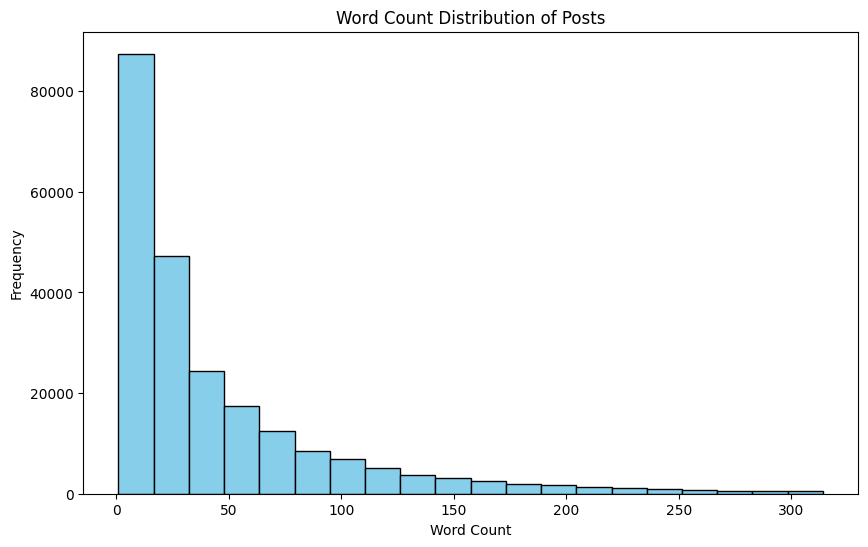

In [ ]:
data['word_count'] = data['cleaned_text'].apply(lambda x: len(x.split()))
word_count_stats = data['word_count'].describe()
print(word_count_stats)
import matplotlib.pyplot as plt

# Plot the word count distribution using a histogram
plt.figure(figsize=(10, 6))
plt.hist(data['word_count'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution of Posts')
plt.show()

# EDA

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Load the preprocessed data from your drive
data_path = '/content/drive/MyDrive/preprocessed_data.csv'  # Replace with the actual file path
data2 = pd.read_csv(data_path)

In [ ]:
print(data.head())

   Unnamed: 0                                               text        class  \
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide   
1           3  Am I weird I don't get affected by compliments...  non-suicide   
2           4  Finally 2020 is almost over... So I can never ...  non-suicide   
3           8          i need helpjust help me im crying so hard      suicide   
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide   

                                        cleaned_text  word_count  
0  sex wife threaten suicide recently leave wife ...          53  
1  weird not affect compliment come know girl fee...          11  
2   finally hear bad year swear fucking god annoying           8  
3                            need help help cry hard           5  
4  lose hello adam struggle year afraid past year...         176  


In [ ]:
# Get the summary statistics of the numerical columns
print(data.describe())

          Unnamed: 0     word_count
count  228428.000000  228428.000000
mean   174134.430315      44.983470
std    100507.024685      52.525107
min         2.000000       1.000000
25%     87009.500000      11.000000
50%    174347.500000      24.000000
75%    261253.250000      58.000000
max    348110.000000     314.000000


# EDA - data visualization

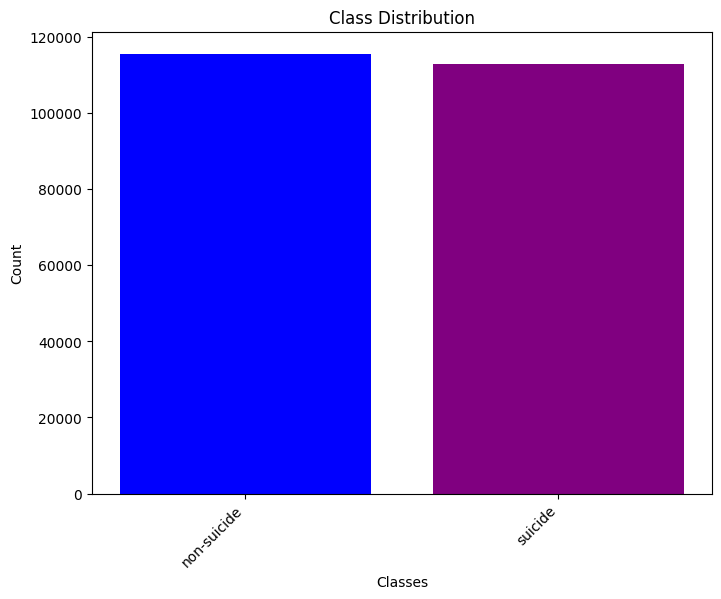

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate class distribution
class_counts = data2['class'].value_counts()

# Sort classes based on their counts in descending order
class_counts = class_counts.sort_values(ascending=False)

# Define colors for the bars (one color for each class)
colors = ['blue', 'purple']

# Plot the class distribution using a bar plot with different colors
plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values, color=colors)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')
plt.show()


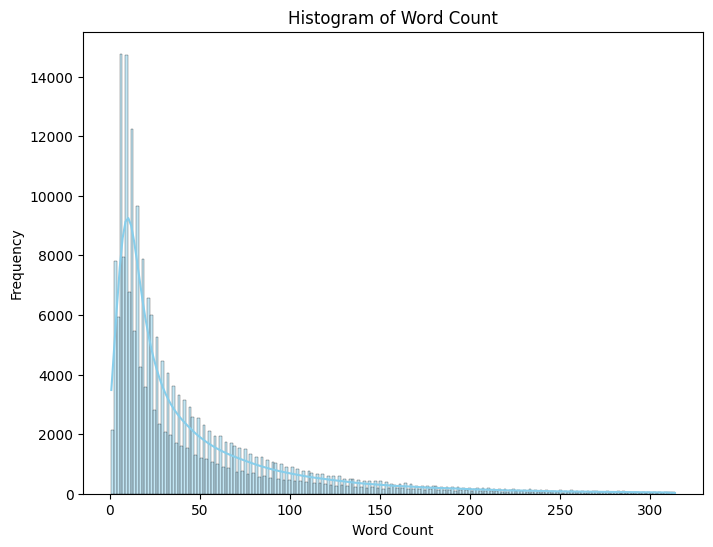

In [ ]:
# Word Count of cleaned_text
data['word_count'] = data['cleaned_text'].apply(lambda x: len(x.split()))

# Histogram of word count
plt.figure(figsize=(8, 6))
sns.histplot(data['word_count'], kde=True, color='skyblue')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Word Count')
plt.show()

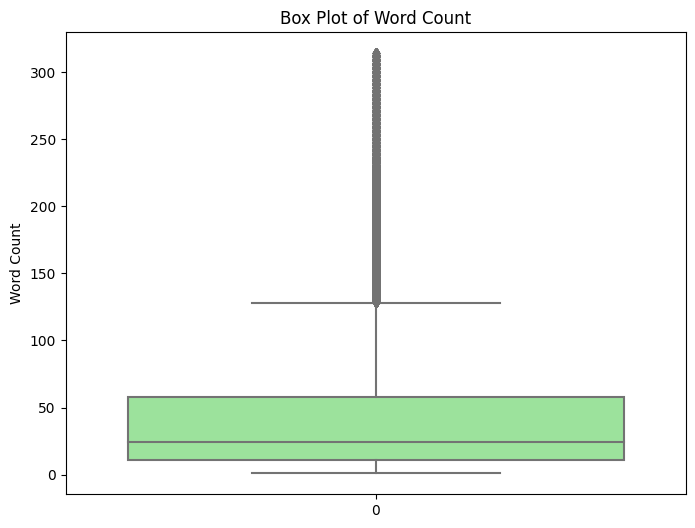

In [ ]:
# Box plot of word count
plt.figure(figsize=(8, 6))
sns.boxplot(data['word_count'], color='lightgreen')
plt.ylabel('Word Count')
plt.title('Box Plot of Word Count')
plt.show()

# Word Frequency Bar Graph

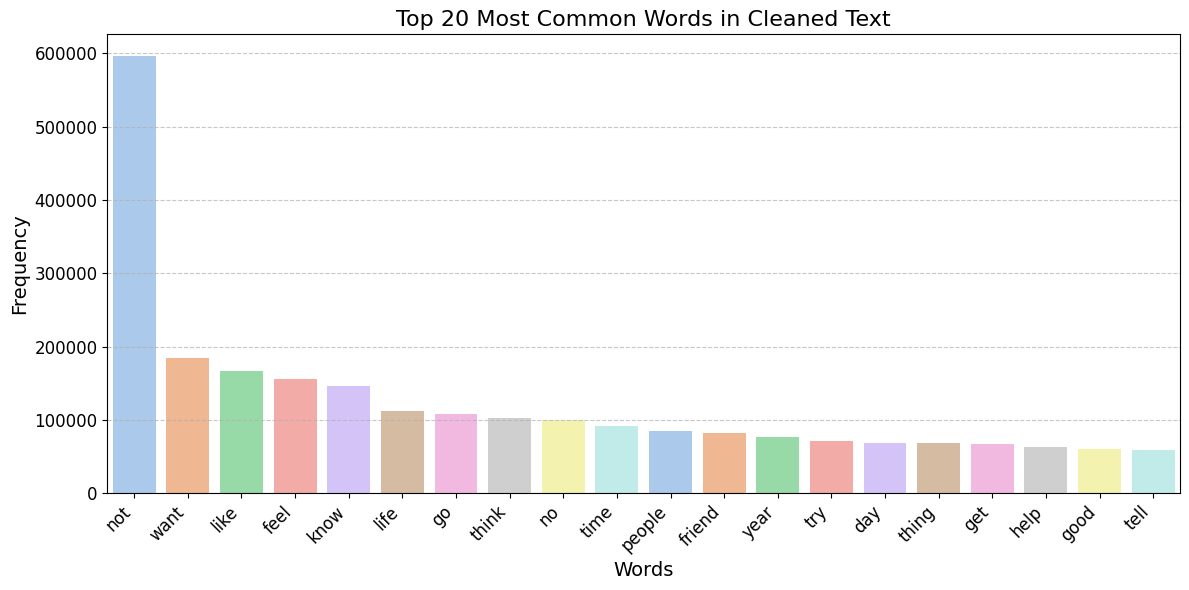

In [ ]:
# Calculate word frequency of cleaned_text
word_freq = data['cleaned_text'].str.split(expand=True).stack().value_counts()

# Top 20 most common words and their frequencies
top_words = word_freq.head(20)

# Plot the word frequency bar graph with colorful bars
plt.figure(figsize=(12, 6))
colors = sns.color_palette("pastel")
sns.barplot(x=top_words.index, y=top_words.values, palette=colors)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 20 Most Common Words in Cleaned Text', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



# Word Cloud

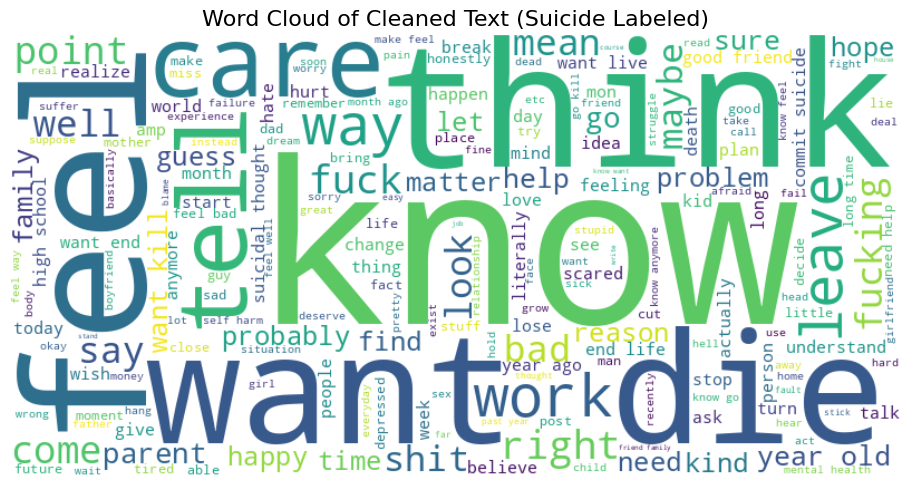

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter data for texts labeled as "suicide"
suicide_data = data2[data2['class'] == 'suicide']

# Combine all words into a single string for suicide texts
wordcloud_text = ' '.join(suicide_data['cleaned_text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Text (Suicide Labeled)', fontsize=16)
plt.tight_layout()
plt.show()


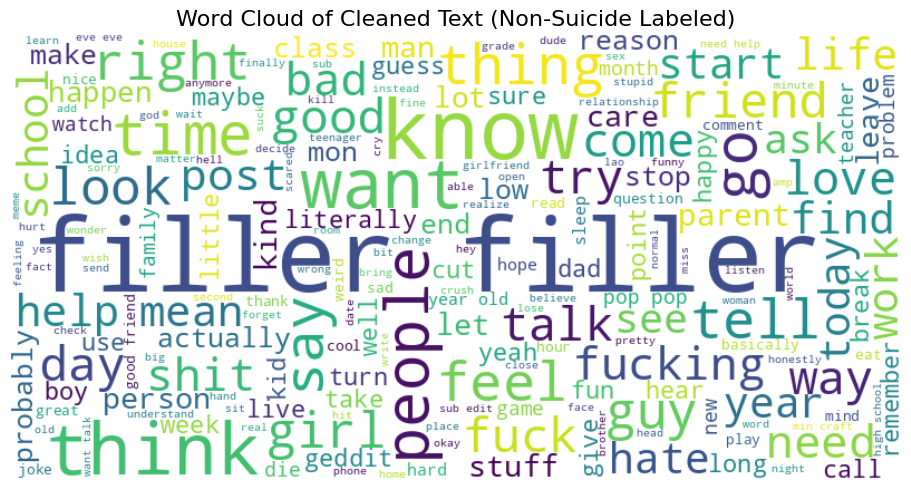

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter data for texts labeled as "suicide"
suicide_data = data2[data2['class'] == 'non-suicide']

# Combine all words into a single string for suicide texts
wordcloud_text = ' '.join(suicide_data['cleaned_text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Text (Non-Suicide Labeled)', fontsize=16)
plt.tight_layout()
plt.show()

# Feature Extraction

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Load the preprocessed data from 'preprocessed_data2.csv'
data2 = pd.read_csv('preprocessed_data.csv')

# Extract features using CountVectorizer (Bag-of-Words representation)
count_vectorizer = CountVectorizer()
count_features = count_vectorizer.fit_transform(data2['cleaned_text'])

# Extract features using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_features = tfidf_vectorizer.fit_transform(data2['cleaned_text'])

# Print the shape of the extracted features
print("Count Vectorizer features shape:", count_features.shape)
print("TF-IDF Vectorizer features shape:", tfidf_features.shape)

Count Vectorizer features shape: (228428, 37982)
TF-IDF Vectorizer features shape: (228428, 37982)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Split the data into training and testing sets for CountVectorizer features
X_train_count, X_test_count, y_train, y_test = train_test_split(count_features, data2['class'], test_size=0.2, random_state=42)

# Split the data into training and testing sets for TF-IDF features
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(tfidf_features, data2['class'], test_size=0.2, random_state=42)

# Label encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
X_train, X_test, y_train, y_test = train_test_split(data2['cleaned_text'], data2['class'], test_size=0.2, random_state=42)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Create a tokenizer to convert text to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Vocabulary size calculation
vocab_size = len(tokenizer.word_index) + 1
vocab_size

35800

# LSTM 2

In [ ]:
# Create a tokenizer to convert text to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences and pad them to a fixed length
max_sequence_length = 100
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)

# Build the LSTM model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
# Build a simpler LSTM model with dropout and L2 regularization
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(units=64, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer='l2'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Implement early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
epochs = 30
batch_size = 32
model.fit(X_train_padded, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/30
5140/5140 [==============================] - 1373s 267ms/step - loss: 0.2503 - accuracy: 0.9131 - val_loss: 0.2108 - val_accuracy: 0.9266
Epoch 2/30
5140/5140 [==============================] - 1350s 263ms/step - loss: 0.1932 - accuracy: 0.9316 - val_loss: 0.1980 - val_accuracy: 0.9296
Epoch 3/30
5140/5140 [==============================] - 1353s 263ms/step - loss: 0.1816 - accuracy: 0.9358 - val_loss: 0.1997 - val_accuracy: 0.9297
Epoch 4/30
5140/5140 [==============================] - 1355s 264ms/step - loss: 0.1744 - accuracy: 0.9384 - val_loss: 0.2086 - val_accuracy: 0.9267
Epoch 5/30
5140/5140 [==============================] - 1350s 263ms/step - loss: 0.1683 - accuracy: 0.9396 - val_loss: 0.1913 - val_accuracy: 0.9289
Epoch 6/30
5140/5140 [==============================] - 1346s 262ms/step - loss: 0.1643 - accuracy: 0.9413 - val_loss: 0.2057 - val_accuracy: 0.9305
Epoch 7/30
5140/5140 [==============================] - 1339s 260ms/step - loss: 0.1796 - accuracy: 0.9416

# LSTM


In [ ]:
# Create a tokenizer to convert text to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences and pad them to a fixed length
max_sequence_length = 100
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)

# Build the LSTM model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(units=128, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
epochs = 30
batch_size = 32
model.fit(X_train_padded, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/10
2570/2570 [==============================] - 1203s 467ms/step - loss: 0.2117 - accuracy: 0.9200 - val_loss: 0.1836 - val_accuracy: 0.9298
Epoch 2/10
2570/2570 [==============================] - 1183s 460ms/step - loss: 0.1659 - accuracy: 0.9374 - val_loss: 0.1904 - val_accuracy: 0.9313
Epoch 3/10
2570/2570 [==============================] - 1192s 464ms/step - loss: 0.1452 - accuracy: 0.9450 - val_loss: 0.1860 - val_accuracy: 0.9288
Epoch 4/10
2570/2570 [==============================] - 1187s 462ms/step - loss: 0.1258 - accuracy: 0.9522 - val_loss: 0.2169 - val_accuracy: 0.9255
Epoch 5/10
2570/2570 [==============================] - 1179s 459ms/step - loss: 0.1111 - accuracy: 0.9578 - val_loss: 0.2149 - val_accuracy: 0.9291
Epoch 6/10
2570/2570 [==============================] - 1180s 459ms/step - loss: 0.0969 - accuracy: 0.9629 - val_loss: 0.2352 - val_accuracy: 0.9274
Epoch 7/10
2570/2570 [==============================] - 1180s 459ms/step - loss: 0.0844 - accuracy: 0.9675

# LSTM 3

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split


# Create a tokenizer to convert text to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences and pad them to a fixed length
max_sequence_length = 100
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)

# Build the LSTM model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

# LSTM layer
model.add(LSTM(units=64, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer='l2'))

# Dense layer
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
epochs = 10
batch_size = 32
model.fit(X_train_padded, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_split=0.1)

# Get predictions on the test data
y_pred = model.predict(X_test_padded)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary classes

# Calculate metrics
precision = precision_score(y_test_encoded, y_pred_classes)
recall = recall_score(y_test_encoded, y_pred_classes)
f1 = f1_score(y_test_encoded, y_pred_classes)

# Print metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/10
5140/5140 [==============================] - 1223s 237ms/step - loss: 0.2528 - accuracy: 0.9137 - val_loss: 0.1998 - val_accuracy: 0.9288
Epoch 2/10
5140/5140 [==============================] - 1216s 237ms/step - loss: 0.1927 - accuracy: 0.9316 - val_loss: 0.1947 - val_accuracy: 0.9296
Epoch 3/10
5140/5140 [==============================] - 1207s 235ms/step - loss: 0.1810 - accuracy: 0.9354 - val_loss: 0.1975 - val_accuracy: 0.9292
Epoch 4/10
5140/5140 [==============================] - 1210s 235ms/step - loss: 0.1737 - accuracy: 0.9378 - val_loss: 0.1914 - val_accuracy: 0.9303
Epoch 5/10
5140/5140 [==============================] - 1203s 234ms/step - loss: 0.1678 - accuracy: 0.9399 - val_loss: 0.1924 - val_accuracy: 0.9293
Epoch 6/10
5140/5140 [==============================] - 1196s 233ms/step - loss: 0.1636 - accuracy: 0.9416 - val_loss: 0.1921 - val_accuracy: 0.9295
Epoch 7/10
5140/5140 [==============================] - 1195s 232ms/step - loss: 0.1601 - accuracy: 0.9428

# LSTM 4

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split


# Create a tokenizer to convert text to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences and pad them to a fixed length
max_sequence_length = 100
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)

# Build the LSTM model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

# LSTM layer
model.add(LSTM(units=64, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer='l2'))

# Dense layer
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
epochs = 6
batch_size = 32
model.fit(X_train_padded, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_split=0.1)

# Get predictions on the test data
y_pred = model.predict(X_test_padded)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary classes

# Calculate metrics
precision = precision_score(y_test_encoded, y_pred_classes)
recall = recall_score(y_test_encoded, y_pred_classes)
f1 = f1_score(y_test_encoded, y_pred_classes)

# Print metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/6
5140/5140 [==============================] - 1262s 245ms/step - loss: 0.2494 - accuracy: 0.9140 - val_loss: 0.2056 - val_accuracy: 0.9283
Epoch 2/6
5140/5140 [==============================] - 1253s 244ms/step - loss: 0.1918 - accuracy: 0.9318 - val_loss: 0.1927 - val_accuracy: 0.9295
Epoch 3/6
5140/5140 [==============================] - 1246s 242ms/step - loss: 0.1798 - accuracy: 0.9363 - val_loss: 0.2002 - val_accuracy: 0.9297
Epoch 4/6
5140/5140 [==============================] - 1251s 243ms/step - loss: 0.1733 - accuracy: 0.9383 - val_loss: 0.1973 - val_accuracy: 0.9315
Epoch 5/6
5140/5140 [==============================] - 1259s 245ms/step - loss: 0.1671 - accuracy: 0.9398 - val_loss: 0.1972 - val_accuracy: 0.9291
Epoch 6/6
1428/1428 [==============================] - 39s 27ms/step
Precision: 0.931227849804854
Recall: 0.9245501514341706
F1 Score: 0.9278769863442325
1428/1428 [==============================] - 37s 26ms/step - loss: 0.1915 - accuracy: 0.9294
Test Loss: 0.

# LSTM + CNN

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

# Assuming you have already loaded and preprocessed your data (X_train, X_test, y_train_encoded, y_test_encoded)

# Create a tokenizer to convert text to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences and pad them to a fixed length
max_sequence_length = 100
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)

# Build the LSTM-CNN model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

# Convolutional layers
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# LSTM layer
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))

# Flatten layer
model.add(Flatten())

# Dense layers
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
epochs = 10
batch_size = 64
model.fit(X_train_padded, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/10
2570/2570 [==============================] - 694s 264ms/step - loss: 0.2144 - accuracy: 0.9198 - val_loss: 0.1887 - val_accuracy: 0.9292
Epoch 2/10
2570/2570 [==============================] - 604s 235ms/step - loss: 0.1639 - accuracy: 0.9402 - val_loss: 0.1867 - val_accuracy: 0.9315
Epoch 3/10
2570/2570 [==============================] - 601s 234ms/step - loss: 0.1283 - accuracy: 0.9538 - val_loss: 0.2180 - val_accuracy: 0.9249
Epoch 4/10
2570/2570 [==============================] - 597s 232ms/step - loss: 0.0956 - accuracy: 0.9657 - val_loss: 0.2362 - val_accuracy: 0.9219
Epoch 5/10
2570/2570 [==============================] - 598s 233ms/step - loss: 0.0704 - accuracy: 0.9750 - val_loss: 0.2806 - val_accuracy: 0.9203
Epoch 6/10
2570/2570 [==============================] - 597s 232ms/step - loss: 0.0542 - accuracy: 0.9807 - val_loss: 0.3776 - val_accuracy: 0.9158
Epoch 7/10
2570/2570 [==============================] - 593s 231ms/step - loss: 0.0423 - accuracy: 0.9851 - val_

# LSTM + CNN 2

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Assuming you have already loaded and preprocessed your data (X_train, X_test, y_train_encoded, y_test_encoded)

# Create a tokenizer to convert text to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences and pad them to a fixed length
max_sequence_length = 100
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)

# Build the LSTM-CNN model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

# Convolutional layers
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# LSTM layer
model.add(LSTM(units=64, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))

# Flatten layer
model.add(Flatten())

# Dense layers
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model without early stopping
epochs = 10
batch_size = 32
model.fit(X_train_padded, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_split=0.1)

# Get predictions on the test data
y_pred = model.predict(X_test_padded)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary classes

# Calculate metrics
precision = precision_score(y_test_encoded, y_pred_classes)
recall = recall_score(y_test_encoded, y_pred_classes)
f1 = f1_score(y_test_encoded, y_pred_classes)

# Print metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/10
5140/5140 [==============================] - 1016s 197ms/step - loss: 0.2149 - accuracy: 0.9195 - val_loss: 0.1864 - val_accuracy: 0.9303
Epoch 2/10
5140/5140 [==============================] - 1013s 197ms/step - loss: 0.1682 - accuracy: 0.9387 - val_loss: 0.1885 - val_accuracy: 0.9305
Epoch 3/10
5140/5140 [==============================] - 1011s 197ms/step - loss: 0.1395 - accuracy: 0.9494 - val_loss: 0.1990 - val_accuracy: 0.9276
Epoch 4/10
5140/5140 [==============================] - 1013s 197ms/step - loss: 0.1126 - accuracy: 0.9590 - val_loss: 0.2383 - val_accuracy: 0.9237
Epoch 5/10
5140/5140 [==============================] - 1006s 196ms/step - loss: 0.0908 - accuracy: 0.9670 - val_loss: 0.2684 - val_accuracy: 0.9221
Epoch 6/10
5140/5140 [==============================] - 1006s 196ms/step - loss: 0.0746 - accuracy: 0.9728 - val_loss: 0.2980 - val_accuracy: 0.9200
Epoch 7/10
5140/5140 [==============================] - 1013s 197ms/step - loss: 0.0628 - accuracy: 0.9772

# LSTM+CNN 3

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Assuming you have already loaded and preprocessed your data (X_train, X_test, y_train_encoded, y_test_encoded)

# Create a tokenizer to convert text to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences and pad them to a fixed length
max_sequence_length = 100
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)

# Build the LSTM-CNN model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

# Convolutional layers
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# LSTM layer
model.add(LSTM(units=64, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))

# Flatten layer
model.add(Flatten())

# Dense layers
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model without early stopping
epochs = 2
batch_size = 64
model.fit(X_train_padded, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_split=0.1)

# Get predictions on the test data
y_pred = model.predict(X_test_padded)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary classes

# Calculate metrics
precision = precision_score(y_test_encoded, y_pred_classes)
recall = recall_score(y_test_encoded, y_pred_classes)
f1 = f1_score(y_test_encoded, y_pred_classes)

# Print metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/2
2570/2570 [==============================] - 660s 255ms/step - loss: 0.2158 - accuracy: 0.9194 - val_loss: 0.1885 - val_accuracy: 0.9278
Epoch 2/2
1428/1428 [==============================] - 40s 28ms/step
Precision: 0.9221993066830488
Recall: 0.936041332620702
F1 Score: 0.9290687650582438
1428/1428 [==============================] - 40s 28ms/step - loss: 0.1860 - accuracy: 0.9298
Test Loss: 0.18603453040122986
Test Accuracy: 0.929759681224823


# CNN

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout




In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.1, random_state=42)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.1, random_state=42)


In [ ]:
# Convert label strings to numerical values
train_labels = np.array([1 if label == 'suicide' else 0 for label in train_labels])
val_labels = np.array([1 if label == 'suicide' else 0 for label in val_labels])
test_labels = np.array([1 if label == 'suicide' else 0 for label in test_labels])

In [ ]:
max_words = 10000
max_sequence_length = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

train_data = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
val_data = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post')
test_data = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')


In [ ]:
embedding_dim = 300
num_filters = 128
filter_size = 5

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
batch_size = 12
epochs = 2

history = model.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(val_data, val_labels))


Epoch 1/2
13486/13486 [==============================] - 155s 11ms/step - loss: 0.2138 - accuracy: 0.9194 - val_loss: 0.1858 - val_accuracy: 0.9308
Epoch 2/2
13486/13486 [==============================] - 84s 6ms/step - loss: 0.1631 - accuracy: 0.9404 - val_loss: 0.1787 - val_accuracy: 0.9320


In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


625/625 [==============================] - 2s 3ms/step - loss: 0.1854 - accuracy: 0.9288
Test Loss: 0.18540671467781067
Test Accuracy: 0.9288288354873657


In [ ]:
from sklearn.metrics import classification_report

# Predict on the test data
predictions = model.predict(test_data)
predicted_labels = [1 if pred > 0.5 else 0 for pred in predictions]

# Calculate precision, recall, and F1 score
report = classification_report(test_labels, predicted_labels, target_names=['non-suicide', 'suicide'])

print("Classification Report:\n", report)


625/625 [==============================] - 1s 2ms/step
Classification Report:
               precision    recall  f1-score   support

 non-suicide       0.92      0.94      0.93     10094
     suicide       0.94      0.91      0.93      9886

    accuracy                           0.93     19980
   macro avg       0.93      0.93      0.93     19980
weighted avg       0.93      0.93      0.93     19980



In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss[epoch]:.4f} - Train Accuracy: {train_acc[epoch]:.4f}")
    print(f"Validation Loss: {val_loss[epoch]:.4f} - Validation Accuracy: {val_acc[epoch]:.4f}")


Epoch 1/2
Train Loss: 0.2138 - Train Accuracy: 0.9194
Validation Loss: 0.1858 - Validation Accuracy: 0.9308
Epoch 2/2
Train Loss: 0.1631 - Train Accuracy: 0.9404
Validation Loss: 0.1787 - Validation Accuracy: 0.9320


# Electra

In [ ]:
import numpy as np
import tensorflow as tf
from transformers import ElectraTokenizer, TFElectraForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

X = data2['cleaned_text']
y = data2['class']  # Replace 'class' with your actual column name for labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to binary format (0 for non-suicide, 1 for suicide)
y_train_binary = (y_train == 'suicide').astype(int)
y_test_binary = (y_test == 'suicide').astype(int)

# Load the ELECTRA tokenizer
tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')

# Tokenize and encode the text data
X_train_encoded = tokenizer(X_train.tolist(), padding='max_length', truncation=True, max_length=100, return_tensors='tf')
X_test_encoded = tokenizer(X_test.tolist(), padding='max_length', truncation=True, max_length=100, return_tensors='tf')

# Load the pre-trained ELECTRA model and build the classification head
model = TFElectraForSequenceClassification.from_pretrained('google/electra-small-discriminator', num_labels=2)  # Binary classification

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Fine-tune the model on your dataset
epochs = 10
batch_size = 32  # Experiment with this value based on your GPU memory
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(
    np.array(X_train_encoded['input_ids']),
    np.array(y_train_binary),
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[early_stopping]
)

# Evaluate the model
loss, accuracy = model.evaluate(np.array(X_test_encoded['input_ids']), np.array(y_test_binary))
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Make predictions and calculate metrics
y_pred = model.predict(np.array(X_test_encoded['input_ids']))
y_pred_classes = np.argmax(y_pred.logits, axis=1)

precision = precision_score(y_test_binary, y_pred_classes)
recall = recall_score(y_test_binary, y_pred_classes)
f1 = f1_score(y_test_binary, y_pred_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraForSequenceClassification: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
5140/5140 [==============================] - 911s 167ms/step - loss: 0.2264 - accuracy: 0.9138 - val_loss: 0.1939 - val_accuracy: 0.9245
Epoch 2/10
5140/5140 [==============================] - 792s 154ms/step - loss: 0.1704 - accuracy: 0.9365 - val_loss: 0.1755 - val_accuracy: 0.9306
Epoch 3/10
5140/5140 [==============================] - 780s 152ms/step - loss: 0.1492 - accuracy: 0.9449 - val_loss: 0.1742 - val_accuracy: 0.9324
Epoch 4/10
5140/5140 [==============================] - 780s 152ms/step - loss: 0.1305 - accuracy: 0.9519 - val_loss: 0.1687 - val_accuracy: 0.9394
Epoch 5/10
5140/5140 [==============================] - 779s 151ms/step - loss: 0.1151 - accuracy: 0.9576 - val_loss: 0.1833 - val_accuracy: 0.9344
Epoch 6/10
1428/1428 [==============================] - 91s 64ms/step - loss: 0.1730 - accuracy: 0.9372
Test Loss: 0.1729719042778015
Test Accuracy: 0.9371579885482788
1428/1428 [==============================] - 93s 63ms/step
Precision: 0.9219861212878755
Rec

# Electra2

In [ ]:
import numpy as np
import tensorflow as tf
from transformers import ElectraTokenizer, TFElectraForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

X = data2['cleaned_text']
y = data2['class']  # Replace 'class' with your actual column name for labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to binary format (0 for non-suicide, 1 for suicide)
y_train_binary = (y_train == 'suicide').astype(int)
y_test_binary = (y_test == 'suicide').astype(int)

# Load the ELECTRA tokenizer
tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')

# Tokenize and encode the text data
X_train_encoded = tokenizer(X_train.tolist(), padding='max_length', truncation=True, max_length=100, return_tensors='tf')
X_test_encoded = tokenizer(X_test.tolist(), padding='max_length', truncation=True, max_length=100, return_tensors='tf')

# Load the pre-trained ELECTRA model and build the classification head
model = TFElectraForSequenceClassification.from_pretrained('google/electra-small-discriminator', num_labels=2)  # Binary classification

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Fine-tune the model on your dataset
epochs = 4
batch_size = 32  # Experiment with this value based on your GPU memory

history = model.fit(
    np.array(X_train_encoded['input_ids']),
    np.array(y_train_binary),
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1
)

# Evaluate the model
loss, accuracy = model.evaluate(np.array(X_test_encoded['input_ids']), np.array(y_test_binary))
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Make predictions and calculate metrics
y_pred = model.predict(np.array(X_test_encoded['input_ids']))
y_pred_classes = np.argmax(y_pred.logits, axis=1)

precision = precision_score(y_test_binary, y_pred_classes)
recall = recall_score(y_test_binary, y_pred_classes)
f1 = f1_score(y_test_binary, y_pred_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraForSequenceClassification: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
5140/5140 [==============================] - 922s 167ms/step - loss: 0.2258 - accuracy: 0.9147 - val_loss: 0.1959 - val_accuracy: 0.9250
Epoch 2/4
5140/5140 [==============================] - 792s 154ms/step - loss: 0.1701 - accuracy: 0.9365 - val_loss: 0.1689 - val_accuracy: 0.9348
Epoch 3/4
5140/5140 [==============================] - 786s 153ms/step - loss: 0.1494 - accuracy: 0.9447 - val_loss: 0.1677 - val_accuracy: 0.9369
Epoch 4/4
1428/1428 [==============================] - 91s 64ms/step - loss: 0.1810 - accuracy: 0.9343
Test Loss: 0.18099801242351532
Test Accuracy: 0.9343124628067017
1428/1428 [==============================] - 94s 63ms/step
Precision: 0.911139294018178
Recall: 0.9599590236949938
F1 Score: 0.9349122692866593


# ELECTRA final

In [ ]:
import numpy as np
import tensorflow as tf
from transformers import ElectraTokenizer, TFElectraForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

X = data2['text']
y = data2['class']  # Replace 'class' with your actual column name for labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to binary format (0 for non-suicide, 1 for suicide)
y_train_binary = (y_train == 'suicide').astype(int)
y_test_binary = (y_test == 'suicide').astype(int)

# Load the ELECTRA tokenizer
tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')

# Tokenize and encode the text data
X_train_encoded = tokenizer(X_train.tolist(), padding='max_length', truncation=True, max_length=100, return_tensors='tf')
X_test_encoded = tokenizer(X_test.tolist(), padding='max_length', truncation=True, max_length=100, return_tensors='tf')

# Load the pre-trained ELECTRA model and build the classification head
model = TFElectraForSequenceClassification.from_pretrained('google/electra-small-discriminator', num_labels=2)  # Binary classification

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Fine-tune the model on your dataset
epochs = 2
batch_size = 64  # Experiment with this value based on your GPU memory

history = model.fit(
    np.array(X_train_encoded['input_ids']),
    np.array(y_train_binary),
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1
)

# Evaluate the model
loss, accuracy = model.evaluate(np.array(X_test_encoded['input_ids']), np.array(y_test_binary))
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Make predictions and calculate metrics
y_pred = model.predict(np.array(X_test_encoded['input_ids']))
y_pred_classes = np.argmax(y_pred.logits, axis=1)

precision = precision_score(y_test_binary, y_pred_classes)
recall = recall_score(y_test_binary, y_pred_classes)
f1 = f1_score(y_test_binary, y_pred_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraForSequenceClassification: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
2570/2570 [==============================] - 764s 278ms/step - loss: 0.1406 - accuracy: 0.9493 - val_loss: 0.0775 - val_accuracy: 0.9728
Epoch 2/2
1428/1428 [==============================] - 94s 66ms/step - loss: 0.0809 - accuracy: 0.9708
Test Loss: 0.08088771253824234
Test Accuracy: 0.9707568883895874
1428/1428 [==============================] - 95s 64ms/step
Precision: 0.9638024951678088
Recall: 0.9771957954747906
F1 Score: 0.9704529370134466


# BERT

In [ ]:
!pip install tensorflow
!pip install transformers
!pip install scikit-learn
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

In [ ]:
X = data2['cleaned_text']
y = data2['class']  # Replace 'class' with your actual column name for labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to binary format (0 for non-suicide, 1 for suicide)
y_train_binary = (y_train == 'suicide').astype(int)
y_test_binary = (y_test == 'suicide').astype(int)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode the text data
X_train_encoded = tokenizer(X_train.tolist(), padding='max_length', truncation=True, max_length=100, return_tensors='tf')
X_test_encoded = tokenizer(X_test.tolist(), padding='max_length', truncation=True, max_length=100, return_tensors='tf')

# Load the pre-trained BERT model and build the classification head
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # Binary classification

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train the model with reduced epochs, optimized batch size, and early stopping
epochs = 10
batch_size = 32  # Experiment with this value based on your GPU memory
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(
    np.array(X_train_encoded['input_ids']),
    np.array(y_train_binary),
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[early_stopping]
)

# Evaluate the model
loss, accuracy = model.evaluate(np.array(X_test_encoded['input_ids']), np.array(y_test_binary))
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Make predictions and calculate metrics
y_pred = model.predict(np.array(X_test_encoded['input_ids']))
y_pred_classes = np.argmax(y_pred.logits, axis=1)

precision = precision_score(y_test_binary, y_pred_classes)
recall = recall_score(y_test_binary, y_pred_classes)
f1 = f1_score(y_test_binary, y_pred_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
5140/5140 [==============================] - 3535s 678ms/step - loss: 0.1875 - accuracy: 0.9286 - val_loss: 0.1610 - val_accuracy: 0.9387
Epoch 2/10
5140/5140 [==============================] - 3481s 677ms/step - loss: 0.1307 - accuracy: 0.9522 - val_loss: 0.1554 - val_accuracy: 0.9430
Epoch 3/10
5140/5140 [==============================] - 3481s 677ms/step - loss: 0.0879 - accuracy: 0.9688 - val_loss: 0.1901 - val_accuracy: 0.9409
Epoch 4/10
1428/1428 [==============================] - 316s 221ms/step - loss: 0.1530 - accuracy: 0.9427
Test Loss: 0.15304890275001526
Test Accuracy: 0.9426957964897156
1428/1428 [==============================] - 315s 219ms/step
Precision: 0.941973437917818
Recall: 0.9413860680562979
F1 Score: 0.9416796613945199


# BERT 2

In [ ]:
X = data2['cleaned_text']
y = data2['class']  # Replace 'class' with your actual column name for labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to binary format (0 for non-suicide, 1 for suicide)
y_train_binary = (y_train == 'suicide').astype(int)
y_test_binary = (y_test == 'suicide').astype(int)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode the text data
X_train_encoded = tokenizer(X_train.tolist(), padding='max_length', truncation=True, max_length=100, return_tensors='tf')
X_test_encoded = tokenizer(X_test.tolist(), padding='max_length', truncation=True, max_length=100, return_tensors='tf')

# Load the pre-trained BERT model and build the classification head
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # Binary classification

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train the model
epochs = 2
batch_size = 32

history = model.fit(
    np.array(X_train_encoded['input_ids']),
    np.array(y_train_binary),
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1
)

# Evaluate the model
loss, accuracy = model.evaluate(np.array(X_test_encoded['input_ids']), np.array(y_test_binary))
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Make predictions and calculate metrics
y_pred = model.predict(np.array(X_test_encoded['input_ids']))
y_pred_classes = np.argmax(y_pred.logits, axis=1)

precision = precision_score(y_test_binary, y_pred_classes)
recall = recall_score(y_test_binary, y_pred_classes)
f1 = f1_score(y_test_binary, y_pred_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
5140/5140 [==============================] - 3621s 694ms/step - loss: 0.1886 - accuracy: 0.9286 - val_loss: 0.1632 - val_accuracy: 0.9384
Epoch 2/2
1428/1428 [==============================] - 322s 226ms/step - loss: 0.1531 - accuracy: 0.9426
Test Loss: 0.15309904515743256
Test Accuracy: 0.9426301121711731
1428/1428 [==============================] - 323s 223ms/step
Precision: 0.939458405353898
Recall: 0.9441029752360591
F1 Score: 0.941774963900922


# final bert

In [ ]:
X = data2['text']
y = data2['class']  # Replace 'class' with your actual column name for labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to binary format (0 for non-suicide, 1 for suicide)
y_train_binary = (y_train == 'suicide').astype(int)
y_test_binary = (y_test == 'suicide').astype(int)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode the text data
X_train_encoded = tokenizer(X_train.tolist(), padding='max_length', truncation=True, max_length=100, return_tensors='tf')
X_test_encoded = tokenizer(X_test.tolist(), padding='max_length', truncation=True, max_length=100, return_tensors='tf')

# Load the pre-trained BERT model and build the classification head
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # Binary classification

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train the model
epochs = 2
batch_size = 32

history = model.fit(
    np.array(X_train_encoded['input_ids']),
    np.array(y_train_binary),
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1
)

# Evaluate the model
loss, accuracy = model.evaluate(np.array(X_test_encoded['input_ids']), np.array(y_test_binary))
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Make predictions and calculate metrics
y_pred = model.predict(np.array(X_test_encoded['input_ids']))
y_pred_classes = np.argmax(y_pred.logits, axis=1)

precision = precision_score(y_test_binary, y_pred_classes)
recall = recall_score(y_test_binary, y_pred_classes)
f1 = f1_score(y_test_binary, y_pred_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
5140/5140 [==============================] - 3589s 689ms/step - loss: 0.0945 - accuracy: 0.9651 - val_loss: 0.0643 - val_accuracy: 0.9767
Epoch 2/2
1428/1428 [==============================] - 322s 226ms/step - loss: 0.0706 - accuracy: 0.9771
Test Loss: 0.07060015946626663
Test Accuracy: 0.9771046042442322
1428/1428 [==============================] - 321s 222ms/step
Precision: 0.9785388536170974
Recall: 0.9747906645287725
F1 Score: 0.9766611629256103


1428/1428 [==============================] - 319s 223ms/step


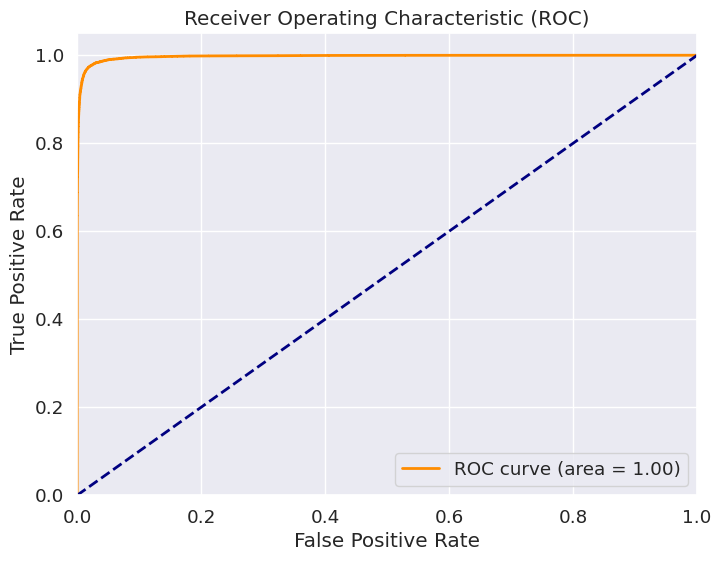

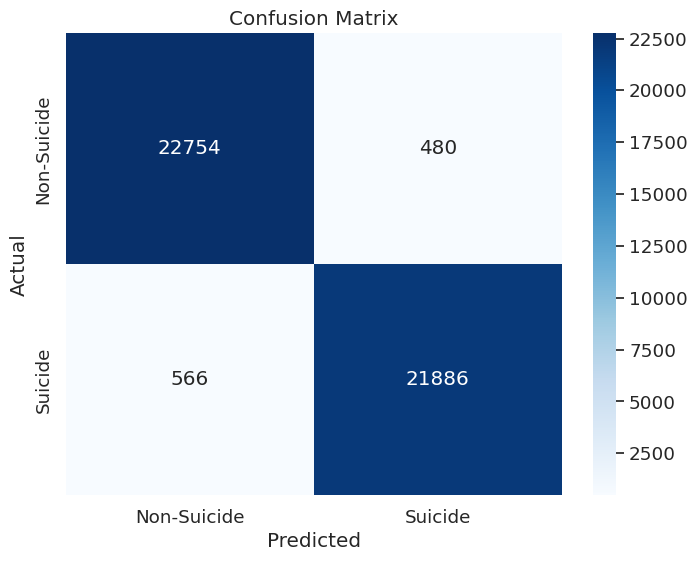

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Calculate the ROC curve and AUC score
# Make predictions
y_pred = model.predict(np.array(X_test_encoded['input_ids']))
y_pred_probs = tf.nn.softmax(y_pred.logits, axis=-1)  # Apply softmax to logits

# Calculate the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_probs[:, 1])
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_test_binary, y_pred_classes)

# Convert the confusion matrix tensor to a NumPy array
confusion_matrix_np = confusion_matrix.numpy()

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion_matrix_np, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Suicide', 'Suicide'], yticklabels=['Non-Suicide', 'Suicide'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()